In [72]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

In [73]:
# Importing data and creating a county dictionary

filename = 'GasStationDataSet_Partial.csv'
rawdat = pd.read_csv(filename)

counties = {
    22005: {'Name' : "Ascension", 'Population': 125061},
    22007: {'Name' : "Assumption", 'Population': 22236},
    22033: {'Name' : "East Baton Rouge", 'Population': 443158},
    22047: {'Name' : "Iberville", 'Population': 32626},
    22051: {'Name' : "Jefferson", 'Population': 434903},
    22057: {'Name' : "Lafourche", 'Population': 97980},
    22063: {'Name' : "Livingston", 'Population': 140524},
    22071: {'Name' : "Orleans", 'Population': 391249},
    22075: {'Name' : "Plaquemines", 'Population': 23305},
    22105: {'Name' : 'Tangipahoa', 'Population': 133753},
    22109: {'Name' : 'Terrebonne', 'Population': 111297},
    22117: {'Name' : 'Washington', 'Population': 46325}
    
}

In [74]:
# Organizing data into a standard datetime format

rawdat['time'] = [time.split(':')[0] + ':00' for time in rawdat['time']]
rawdat['datetime'] = pd.to_datetime(rawdat['date'] + ' ' + rawdat['time'])
rawdat.drop(['time','date'],axis=1,inplace=True)

outside = rawdat['FIPS']
inside = rawdat['datetime']
hier_index = list(zip(outside,inside))
hier_index = pd.MultiIndex.from_tuples(hier_index)
rawdat.set_index(hier_index, inplace=True)

rawdat.drop(['postalcode','datetime','FIPS','PercentageOperational'], axis=1, inplace=True)
rawdat.index.names = ['FIPS','datetime']

In [75]:
# Creating relevant features, dropping unimportant/bad features, organizing data
# Two final products: combined_county_data, and lateral_combined_data

data_by_county = {}
combined_county_data = pd.DataFrame()
lateral_combined_data = pd.DataFrame()
for FIP in counties:
    data_by_county[counties[FIP]['Name']] = rawdat.loc[FIP].groupby('datetime').sum()
    
    data_by_county[counties[FIP]['Name']]['FIPS'] = counties[FIP]['Name']
    data_by_county[counties[FIP]['Name']]['PercentageOperational'] = data_by_county[counties[FIP]['Name']]['Has Fuel:Has Power']/data_by_county[counties[FIP]['Name']]['Total Stations']
    data_by_county[counties[FIP]['Name']]['1 Day Moving Avg PercentageOperational'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=3).mean()
    data_by_county[counties[FIP]['Name']]['2 Day Moving Avg PercentageOperational'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).mean()
    data_by_county[counties[FIP]['Name']]['3 Day Moving Avg PercentageOperational'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).mean()
    data_by_county[counties[FIP]['Name']]['2 Day Minimum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).min()
    data_by_county[counties[FIP]['Name']]['3 Day Minimum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).min()
    data_by_county[counties[FIP]['Name']]['2 Day Maximum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).max()
    data_by_county[counties[FIP]['Name']]['3 Day Maximum'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).max()
    data_by_county[counties[FIP]['Name']]['1 Day Std'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=3).std()
    data_by_county[counties[FIP]['Name']]['2 Day Std'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=6).std()
    data_by_county[counties[FIP]['Name']]['3 Day Std'] = data_by_county[counties[FIP]['Name']]['PercentageOperational'].rolling(window=9).std()
    data_by_county[counties[FIP]['Name']].drop(columns=['Total Stations', 'Has Fuel:Has Power', 'Has Fuel:No Power', 'No Fuel:Has Power', 'No Power:No Fuel', 'raw_visit_counts'], inplace=True)
    combined_county_data = pd.concat([combined_county_data, data_by_county[counties[FIP]['Name']]])

    data_by_county[counties[FIP]['Name']].columns = [ str(counties[FIP]['Name']) + ' ' + name for name in list(data_by_county[counties[FIP]['Name']])]
    lateral_combined_data = pd.concat([lateral_combined_data, data_by_county[counties[FIP]['Name']]], axis=1)

In [76]:
# Make categorical county label readable for model using one hot encoding

onehot_parish = pd.get_dummies(combined_county_data.FIPS, prefix = 'Parish', drop_first=True)
combined_county_data = pd.concat([combined_county_data, onehot_parish], axis=1)

In [77]:
# Create target variable as the percentage operational, 3 data points (24 hours) ahead
# Split data into train and test sets

combined_county_data.dropna(inplace=True)
y = combined_county_data['PercentageOperational'].iloc[3:]
combined_county_data.rename(columns={'PercentageOperational': 'PrevDay PercentageOperational'}, inplace=True)
combined_county_data.drop(columns='FIPS', inplace=True)
X = combined_county_data[:-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [78]:
# Create a linear regression model as baseline
results = {}

LR = LinearRegression()
LR.fit(X_train,y_train)

LR_pred_train = LR.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,LR_pred_train)
MSE = metrics.mean_squared_error(y_train,LR_pred_train)
RMSE = metrics.mean_squared_error(y_train,LR_pred_train, squared=False)
print('\nLinear Regression Training Performance:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

LR_pred = LR.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,LR_pred)
test_MSE = metrics.mean_squared_error(y_test,LR_pred)
test_RMSE = metrics.mean_squared_error(y_test,LR_pred, squared=False)
print('\nLinear Regression Testing Performance:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['LinearRegression'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]


Linear Regression Training Performance:
MAE = 0.04559122356992925
MSE = 0.00844308051959753
RMSE = 0.09188623683445486

Linear Regression Testing Performance:
MAE = 0.04587130726467247
MSE = 0.008308538749948604
RMSE = 0.09115118622348589


In [79]:
# Try Ridge Regression with different Alpha params

train_error_RMSE = []
test_error_RMSE = []
train_error_MAE = []
test_error_MAE = []
i = [0.00001, 0.0001, 0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

for alpha in i:
    
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    MAE = metrics.mean_absolute_error(y_train,y_pred)
    MSE = metrics.mean_squared_error(y_train,y_pred)
    RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
    train_error_RMSE.append(RMSE)
    train_error_MAE.append(MAE)

    y_pred_test = clf.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test,y_pred_test)
    MSE = metrics.mean_squared_error(y_test,y_pred_test)
    RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
    test_error_RMSE.append(RMSE)
    test_error_MAE.append(MAE)

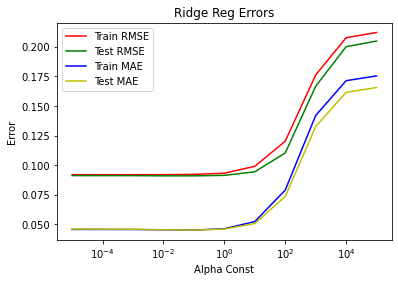

In [80]:
# Choose a good Alpha param (alpha=10 appears good)

plt.plot(i, train_error_RMSE, color='r', label='Train RMSE')
plt.plot(i, test_error_RMSE, color='g', label='Test RMSE')
plt.plot(i, train_error_MAE, color='b', label='Train MAE')
plt.plot(i, test_error_MAE, color='y', label='Test MAE')
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Ridge Reg Errors")
plt.legend()
plt.xscale('log')

In [81]:
# Best Ridge model

clf = Ridge(alpha=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,y_pred)
MSE = metrics.mean_squared_error(y_train,y_pred)
RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
print('\nRidge Regression Training Performance:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

y_pred_test = clf.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,y_pred_test)
test_MSE = metrics.mean_squared_error(y_test,y_pred_test)
test_RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
print('\nRidge Regression Testing Performance:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['RidgeRegression'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]


Ridge Regression Training Performance:
MAE = 0.05223893605621552
MSE = 0.009792952075041701
RMSE = 0.09895934556696351

Ridge Regression Testing Performance:
MAE = 0.05057094465178645
MSE = 0.008897232100183484
RMSE = 0.0943251403401208


In [82]:
#Try Lasso Regression with different Alpha params

train_error_RMSE = []
test_error_RMSE = []
train_error_MAE = []
test_error_MAE = []
i = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for alpha in i:
    
    lasso = Lasso(alpha=alpha, max_iter=10000000)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_train)
    MAE = metrics.mean_absolute_error(y_train,y_pred)
    MSE = metrics.mean_squared_error(y_train,y_pred)
    RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
    train_error_RMSE.append(RMSE)
    train_error_MAE.append(MAE)

    y_pred_test = lasso.predict(X_test)
    MAE = metrics.mean_absolute_error(y_test,y_pred_test)
    MSE = metrics.mean_squared_error(y_test,y_pred_test)
    RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
    test_error_RMSE.append(RMSE)
    test_error_MAE.append(MAE)    

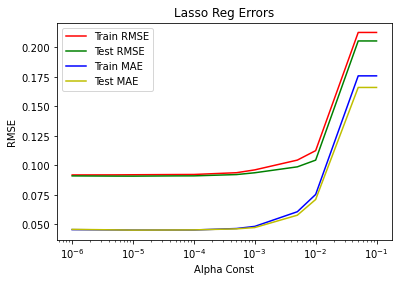

In [83]:
#Choose a good Alpha param (alpha=0.002 is good)

plt.plot(i, train_error_RMSE, color='r', label='Train RMSE')
plt.plot(i, test_error_RMSE, color='g', label='Test RMSE')
plt.plot(i, train_error_MAE, color='b', label='Train MAE')
plt.plot(i, test_error_MAE, color='y', label='Test MAE')
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Lasso Reg Errors")
plt.legend()
plt.xscale('log')

In [84]:
# Best Lasso Model

lasso = Lasso(alpha=0.002)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,y_pred)
MSE = metrics.mean_squared_error(y_train,y_pred)
RMSE = metrics.mean_squared_error(y_train,y_pred, squared=False)
print('\nLasso Regression Training Performance:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

y_pred_test = lasso.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,y_pred_test)
test_MSE = metrics.mean_squared_error(y_test,y_pred_test)
test_RMSE = metrics.mean_squared_error(y_test,y_pred_test, squared=False)
print('\nLasso Regression Training Performance:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['LassoRegression'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]


Lasso Regression Training Performance:
MAE = 0.052437717234837505
MSE = 0.01010171404684311
RMSE = 0.10050728355120891

Lasso Regression Training Performance:
MAE = 0.05042694465769595
MSE = 0.009330988131433089
RMSE = 0.09659703997241886


In [87]:
# Try PCA with 3 principal components
# Scale data first for PCA

scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

# Split data using PCA features
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=101)

# Perform Linear Regression using PCA features
LR = LinearRegression()
LR.fit(X_train,y_train)

LR_pred = LR.predict(X_train)
MAE = metrics.mean_absolute_error(y_train,LR_pred)
MSE = metrics.mean_squared_error(y_train,LR_pred)
RMSE = metrics.mean_squared_error(y_train,LR_pred, squared=False)
print('PCA error metrics:')
print(f'MAE = {MAE}')
print(f'MSE = {MSE}')
print(f'RMSE = {RMSE}')

LR_pred = LR.predict(X_test)
test_MAE = metrics.mean_absolute_error(y_test,LR_pred)
test_MSE = metrics.mean_squared_error(y_test,LR_pred)
test_RMSE = metrics.mean_squared_error(y_test,LR_pred, squared=False)
print('PCA error metrics:')
print(f'MAE = {test_MAE}')
print(f'MSE = {test_MSE}')
print(f'RMSE = {test_RMSE}')

results['PCA_LinReg'] = [MAE, MSE, RMSE, test_MAE, test_MSE, test_RMSE]

PCA error metrics:
MAE = 0.06095715217218712
MSE = 0.011405114226732564
RMSE = 0.10679472939584876
PCA error metrics:
MAE = 0.060919218155279946
MSE = 0.010535568954478537
RMSE = 0.10264291965098488


<AxesSubplot:>

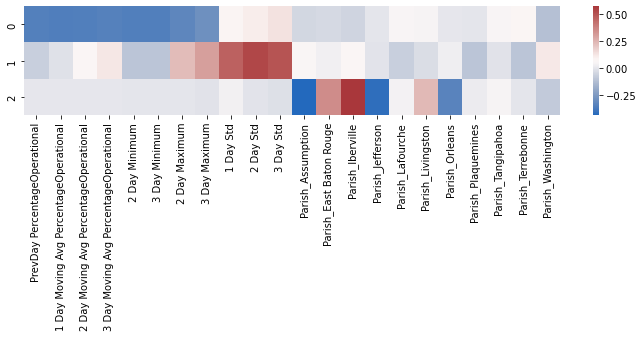

In [88]:
# Visualize component weights

df_comp = pd.DataFrame(pca.components_,columns=X.columns)
plt.figure(figsize=(12,2))
sns.heatmap(df_comp, cmap='vlag')

In [89]:
#PCA component weights

coeffecients = pd.DataFrame(np.transpose(pca.components_),X.columns)
coeffecients.columns = ['1st Component', '2nd Component', '3rd Component']
coeffecients

,1st Component,2nd Component,3rd Component
PrevDay PercentageOperational,-0.349520,-0.068508,0.000679
1 Day Moving Avg PercentageOperational,-0.354859,-0.014095,0.002601
2 Day Moving Avg PercentageOperational,-0.354049,0.064020,0.002808
3 Day Moving Avg PercentageOperational,-0.346022,0.123621,0.002307
2 Day Minimum,-0.352896,-0.101116,-0.000761
3 Day Minimum,-0.350685,-0.101440,0.000149
2 Day Maximum,-0.324644,0.230565,0.000137
3 Day Maximum,-0.287857,0.306294,-0.008564
1 Day Std,0.080512,0.467050,0.034364
2 Day Std,0.108770,0.534668,-0.004055


[Text(0.5, 0, '3rd Component'), Text(0, 0.5, '1st Component')]

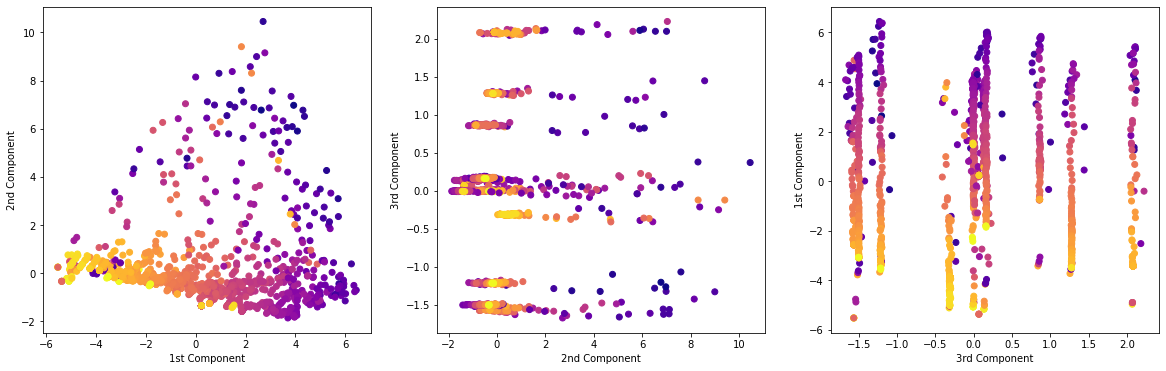

In [90]:
#PCA Component visualization

f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
ax1.scatter(X_pca[:,0],X_pca[:,1], c=y, cmap='plasma')
ax1.set(xlabel='1st Component', ylabel='2nd Component')
ax2.scatter(X_pca[:,1],X_pca[:,2], c=y, cmap='plasma')
ax2.set(xlabel='2nd Component', ylabel='3rd Component')
ax3.scatter(X_pca[:,2],X_pca[:,0], c=y, cmap='plasma')
ax3.set(xlabel='3rd Component', ylabel='1st Component')

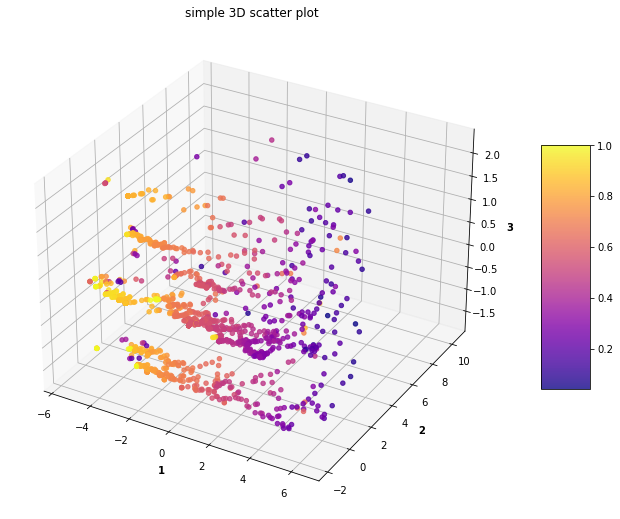

In [91]:
# More PCA visualization 

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('plasma')
 
sctt = ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2],
                    alpha = 0.8,
                    c = y,
                    cmap = my_cmap,)
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('1', fontweight ='bold')
ax.set_ylabel('2', fontweight ='bold')
ax.set_zlabel('3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

In [105]:
# Results as percentages

results_df = (pd.DataFrame(results)*100).round(2)
results_df.index = ['Train MAE', 'Train MSE', 'Train RMSE', 'Test MAE', 'Test MSE', 'Test RMSE']
results_df.transpose()

,Train MAE,Train MSE,Train RMSE,Test MAE,Test MSE,Test RMSE
LinearRegression,4.56,0.84,9.19,4.59,0.83,9.12
RidgeRegression,5.22,0.98,9.90,5.06,0.89,9.43
LassoRegression,5.24,1.01,10.05,5.04,0.93,9.66
PCA_LinReg,6.10,1.14,10.68,6.09,1.05,10.26
